In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from src.encoders_decoders import *
from src.losses import *

ModuleNotFoundError: No module named 'src'

In [25]:
N_EPOCHS =5000
#Define data distribution
p_x = torch.distributions.exponential.Exponential(0.5)

x_data = p_x.sample((1000,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 
print(x_min,x_max)

#encoder = CategoricalEncoder(mu0,sigma0,q0)
N=10
decoder = MoGDecoder(N,x_min,x_max-8)
encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))

#Define optimizer and parameters to iterate on
params =  list(decoder.parameters())
optimizer = torch.optim.SGD([
                {'params': params[0:2]},
                {'params': params[2],'lr':1e-2}
            ],0.01)

0.0016221491387113929 14.868490219116211


In [26]:
#Ideal loss
lossVec = []
DVec = []
mseVec = []
for epoch in range(N_EPOCHS):
    loss = simplified_loss(x_data,decoder)
    lossVec.append(loss.item())
    mse = MSE_cat(x_data,decoder)
    mseVec.append(mse.item())
    #encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))
    #DVec.append(distortion_cat(x_data,encoder,decoder).item())
    optimizer.zero_grad()
    loss.backward()
    #print(decoder.log_sigmas.grad)
    optimizer.step()

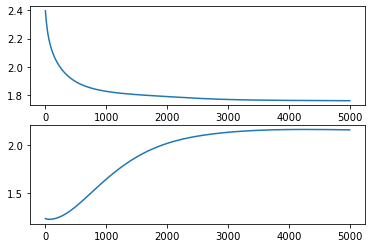

In [27]:
fig, axs = plt.subplots(2);
axs[0].plot(lossVec);
axs[1].plot(mseVec);

<ipython-input-28-f1e4ddc33d7d>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  axs[0].plot(x_fine,F.softmax(encoder(x_fine)[:,:]));


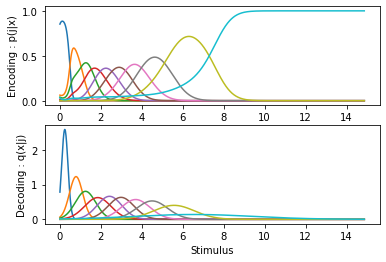

In [28]:
fig, axs = plt.subplots(2);
encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

with torch.no_grad():
    axs[0].set_xlabel("Stimulus");
    axs[0].set_ylabel("Encoding : p(j|x)");
    axs[0].plot(x_fine,F.softmax(encoder(x_fine)[:,:]));  
    gaussian = torch.distributions.normal.Normal(decoder.mus, torch.exp(decoder.log_sigmas))
    a = (gaussian.log_prob(x_fine.transpose(0,1))).transpose(0,1)
    axs[1].plot(x_fine, torch.exp(a[:,:]));
    axs[1].set_xlabel("Stimulus");
    axs[1].set_ylabel("Decoding : q(x|j)");
    #axs[1].set_ylim((0,2))

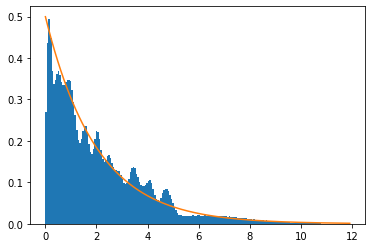

In [12]:
q_sample = torch.squeeze(torch.distributions.categorical.Categorical((F.softmax(decoder.qs,dim=0)).transpose(0,1)).sample((10000,)))
muext,log_sigmaext =decoder(F.one_hot(q_sample).to(dtype=torch.float32))
x_sample = torch.flatten(torch.distributions.normal.Normal(muext,torch.exp(log_sigmaext)).sample((100,)))
with torch.no_grad():
    
    plt.hist(x_sample.numpy(),np.linspace(x_min,x_max,200),density=True)
    plt.plot(torch.linspace(x_min,x_max,200),torch.exp(p_x.log_prob(torch.linspace(x_min,x_max,200))))

In [17]:
#Reinitalize parameters
decoder = MoGDecoder(N,x_min,x_max-5)
encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))
params =  list(encoder.parameters())+list(decoder.parameters())
optimizer = torch.optim.SGD(params,0.01)
lossVec = []
mseVec = []
for epoch in range(N_EPOCHS):
    dis_loss = distortion_cat(x_data,encoder,decoder)
    rate_loss = rate_cat(x_data,encoder,decoder)
    loss = dis_loss + rate_loss
    #loss = simplified_loss(x_data,decoder)
    lossVec.append(loss.item())
    #print(torch.softmax(decoder.qs,dim=1))
    mse = MSE_cat(x_data,decoder,encoder)
    mseVec.append(mse.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

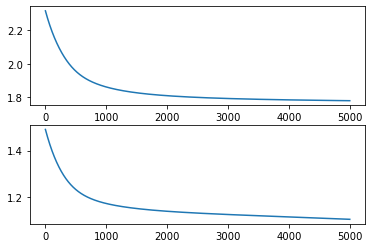

In [18]:
fig, axs = plt.subplots(2);
axs[0].plot(lossVec);
axs[1].plot(mseVec);

<ipython-input-19-d381f4dd7212>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  axs[0].plot(x_fine,F.softmax(encoder(x_fine)[:,:]));


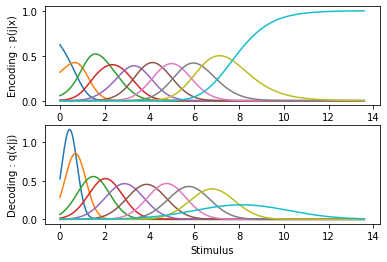

In [19]:
fig, axs = plt.subplots(2);
#encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

with torch.no_grad():
    axs[0].set_xlabel("Stimulus");
    axs[0].set_ylabel("Encoding : p(j|x)");
    axs[0].plot(x_fine,F.softmax(encoder(x_fine)[:,:]));  
    gaussian = torch.distributions.normal.Normal(decoder.mus, torch.exp(decoder.log_sigmas))
    a = (gaussian.log_prob(x_fine.transpose(0,1))).transpose(0,1)
    axs[1].plot(x_fine, torch.exp(a[:,:]));
    axs[1].set_xlabel("Stimulus");
    axs[1].set_ylabel("Decoding : q(x|j)");
    #axs[1].set_ylim((0,2))

In [12]:
MSE_montecarlo(x_data,encoder,decoder)

tensor(9.7434)

In [8]:
MSE_cat(x_data,decoder)

tensor(7.3708, grad_fn=<MeanBackward0>)

In [6]:
r

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        ...,

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 